# Bollinger Bands Strategy and Backtesting Report

******************************************************
**Prepared By : Samalie Piwan**  
**Andrew ID: spiwan**  
**Semester: Fall 2023**  
**Last modified: 26th September 2023**  
******************************************************

## Strategy Implementation

1.Load the libraries to use in the project

In [446]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2.Load the data from the TSLA stock prices for creating the strategy

In [383]:
#Load the data from the downloaded file
tsla_df = pd.read_csv('TSLA.csv')

In [455]:
#Convert the date column to datetime
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
#Set the Date column as the index
tsla_df_indexed = tsla_df.set_index('Date')
#Display the data
tsla_df_indexed.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


3. Define the function **simple_moving_average()** that will calculate the Simple Moving Average for the loaded dataset. We will start with a window of 20 days

In [457]:
#Define a function to compute the simple moving average of the historic data
def simple_moving_average(data, window):
    sma = data.rolling(window = window).mean()
    return sma

#Set the number of days for the window
window = 20

#Run the simple_moving_average on the dataframe
tsla_df_indexed['SMA 20'] = simple_moving_average(tsla_df_indexed['Adj Close'], window)

4. Define the function **create_bands()** that will generate the upper and lower Bollinger Bands for our strategy

In [459]:
#Define a function to create Bollinger Bands from the data
def create_bands(data, sma, window):
    standard_deviation = data.rolling(window = window).std()
    upper_band = sma + standard_deviation * 2
    lower_band = sma - standard_deviation * 2
    return upper_band, lower_band

tsla_df_indexed['Upper Band'], tsla_df_indexed['Lower Band'] = create_bands(tsla_df_indexed['Adj Close'], tsla_df_indexed['SMA 20'], 20)
#Display the updated data
tsla_df_indexed.head()

,Open,High,Low,Close,Adj Close,Volume,SMA 20,Upper Band,Lower Band
Date,,,,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,NaN,NaN,NaN
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,NaN,NaN,NaN
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,NaN,NaN,NaN
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,NaN,NaN,NaN
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,NaN,NaN,NaN


5. Plot a time-series of the TSLA Pricing Data, Simple Moving Average, Upper and Lower bands

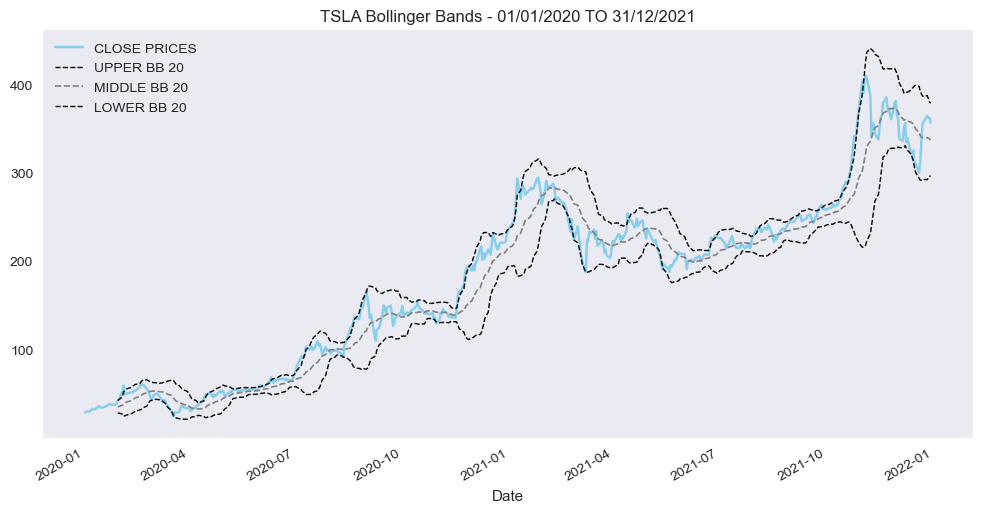

In [460]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(12,6))
plt.title("TSLA Bollinger Bands - 01/01/2020 TO 31/12/2021")
tsla_df_indexed['Adj Close'].plot(label = 'CLOSE PRICES', color = 'skyblue')
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper left')
plt.grid()
plt.show()

6. Define a function **implement_bands_strategy()** to generate the trading signals <br> If the condition to buy the stock gets satisfied, the buying price will be appended to the ‘buy_price’ list, and the signal value will be appended as 1 to represent buying the stock <br> If the condition to sell the stock gets satisfied, the selling price will be appended to the ‘sell_price’ list, and the signal value will be appended as -1 to represent selling the stock

In [403]:
#Define a function to generate the trading signals
def implement_bands_strategy(data, lower_band, upper_band):
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(data[i-1] > lower_band[i-1] and data[i] < lower_band[i]):
            if(signal != 1):
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(data[i-1] < upper_band[i-1] and data[i] > upper_band[i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)
            
    return buy_price, sell_price, bands_signal

buy_price, sell_price, bands_signal = implement_bands_strategy(tsla_df_indexed['Close'], tsla_df_indexed['Lower Band'], tsla_df_indexed['Upper Band'])

7. Plot a time-series of the TSLA Pricing Data, Simple Moving Average, Upper and Lower bands, indicating the sell and buy signals

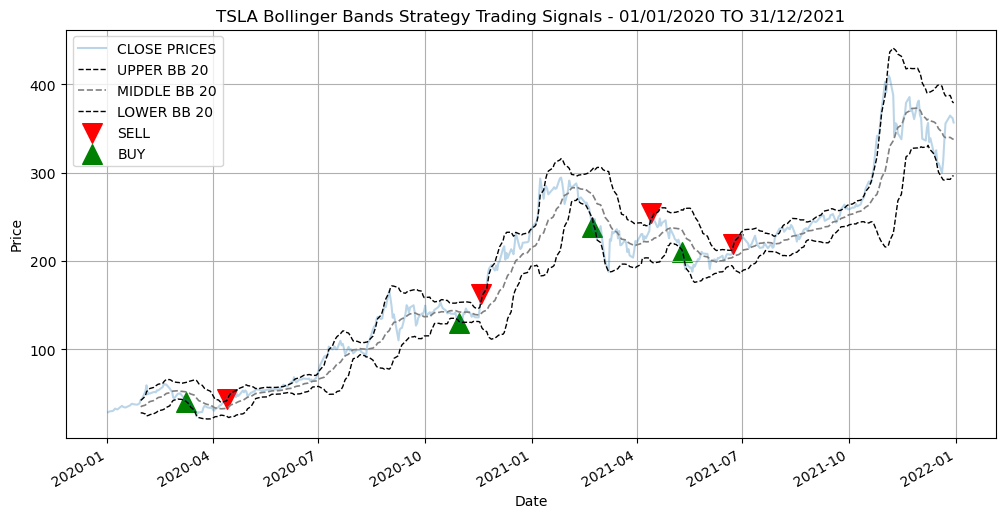

In [436]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("TSLA Bollinger Bands Strategy Trading Signals - 01/01/2020 TO 31/12/2021")
tsla_df_indexed['Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
tsla_df_indexed['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
tsla_df_indexed['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
tsla_df_indexed['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(tsla_df_indexed.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(tsla_df_indexed.index, buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.grid()
plt.show()

8.Create positions for our strategy. **1** represents a long position where we buy stock. **0** represents a short position where we sell stock

In [405]:
#Create positions for our strategy

position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(tsla_df_indexed['Adj Close'])):
    if bands_signal[i] == 1:
        position[i] = 1
    elif bands_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

In [461]:
#Add the bands_signal list to the main dataset
tsla_df_indexed.insert(loc = 9,column = 'Band Signals', value = bands_signal)

#Add the positions list to the main dataset
tsla_df_indexed.insert(loc = 10,column = 'Band Position', value = position)

#Display the updated data
tsla_df_indexed.head()

,Open,High,Low,Close,Adj Close,Volume,SMA 20,Upper Band,Lower Band,Band Signals,Band Position
Date,,,,,,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,NaN,NaN,NaN,0,1
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,NaN,NaN,NaN,0,1
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,NaN,NaN,NaN,0,1
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,NaN,NaN,NaN,0,1
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,NaN,NaN,NaN,0,1


9. Plot the market positions for our pricing data using the 'Band Position' values generated

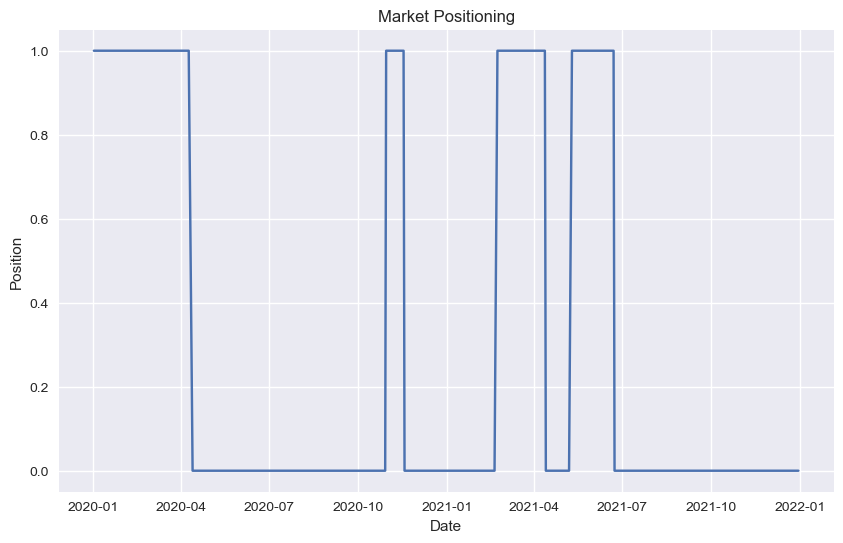

In [445]:
#Plot the market positions
plt.figure(figsize = (10,6))
plt.title("Market Positioning")
plt.xlabel("Date")
plt.ylabel("Position")
plt.plot(tsla_df_indexed['Band Position'])

10. To calculate the performance of the strategy, we calculate the log returns based on the original financial time series

In [462]:
#Calculate the returns on the data
tsla_df_indexed['Returns'] = np.log(tsla_df_indexed['Close'] / tsla_df_indexed['Close'].shift(1))

11. To derive the strategy returns, we multiply the position column—shifted by one trading day—with the returns column. Since log returns are additive, calculating the sum over the columns 'Returns' and 'Strategy' provides a first comparison of the performance of the strategy relative to the base investment itself

In [463]:
#Calculate the performance on the strategy data
tsla_df_indexed['Strategy'] = tsla_df_indexed['Band Position'].shift(1) * tsla_df_indexed['Returns']

12. Calculate the cummulative sum of the 'Returns' and 'Strategy' data

In [467]:
#Compute the cummulative returns from the returns dataset
tsla_df_indexed['Cummulative Strategy'] = tsla_df_indexed['Strategy'].cumsum()
tsla_df_indexed['Cummulative Returns'] = tsla_df_indexed['Returns'].cumsum()

#Display the updated data
tsla_df_indexed.tail()

,Open,High,Low,Close,Adj Close,Volume,SMA 20,Upper Band,Lower Band,Band Signals,Band Position,Returns,Strategy,Cummulative Strategy,Cummulative Returns
Date,,,,,,,,,,,,,,,
2021-12-23,335.600006,357.660004,332.519989,355.666656,355.666656,92713200,339.725501,386.859807,292.591194,0,0,0.056020,0.0,0.748077,2.517654
2021-12-27,357.890015,372.333344,356.906677,364.646667,364.646667,71145900,339.925833,387.466726,292.384940,0,0,0.024935,0.0,0.748077,2.542589
2021-12-28,369.829987,373.000000,359.473328,362.823334,362.823334,60324000,339.117166,384.354167,293.880166,0,0,-0.005013,-0.0,0.748077,2.537577
2021-12-29,366.213318,368.000000,354.713318,362.063324,362.063324,56154000,338.140999,380.253989,296.028009,0,0,-0.002097,-0.0,0.748077,2.535480
2021-12-30,353.776672,365.183319,351.049988,356.779999,356.779999,47040900,337.729999,378.888925,296.571073,0,0,-0.014700,-0.0,0.748077,2.520780


13. Plot cummulative sum of the 'Returns' and 'Strategy' data

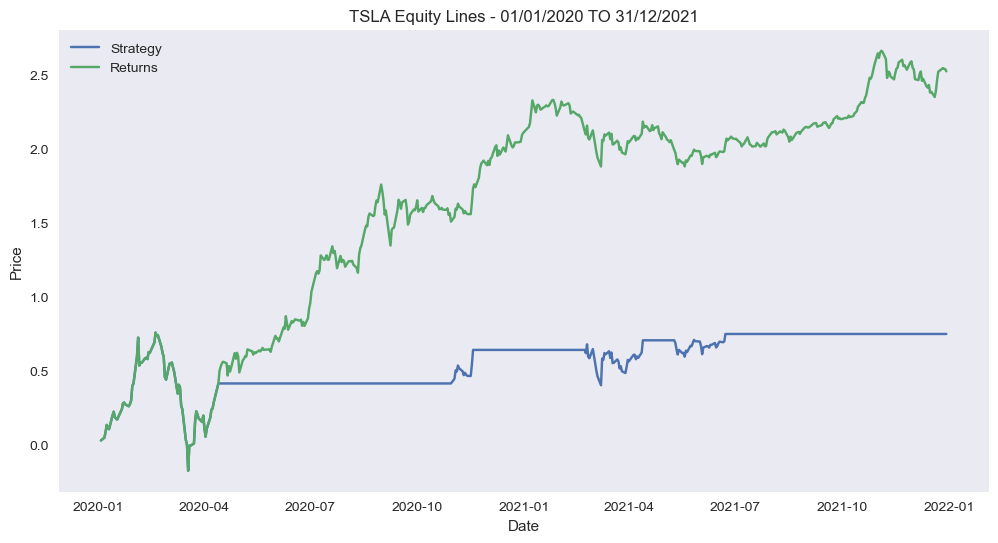

In [447]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("TSLA Equity Lines - 01/01/2020 TO 31/12/2021")
plt.plot(tsla_df_indexed['Cummulative Strategy'], label = "Strategy")
plt.plot(tsla_df_indexed['Cummulative Returns'], label = "Returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.grid()
plt.show()

## Backtesting

1.Load the data Pyalgo Eikon End of Day Data for the for backtesting the strategy

In [469]:
#Load the data from the downloaded file
#Specify the 'Date' column as the index
pylago_eikon_df = pd.read_csv('pyalgo_eikon_eod_data.csv', index_col=0,parse_dates=True).dropna()

#Describe the data
pylago_eikon_df.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


2. Select the Euro pricing from the dataset

In [471]:
#Select the pricing data from the FX dataset
pricing_data = pd.DataFrame(pylago_eikon_df['EUR='])
pricing_data.rename(columns={'EUR=':'Pricing'}, inplace = True)
pricing_data.head()

,Pricing
Date,
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318
2010-01-08,1.4412


3. Find the Simple Moving Average of the FX data

In [473]:
pricing_data['SMA 20'] = simple_moving_average(pricing_data['Pricing'], window)

pricing_data.head()

,Pricing,SMA 20
Date,,
2010-01-04,1.4411,NaN
2010-01-05,1.4368,NaN
2010-01-06,1.4412,NaN
2010-01-07,1.4318,NaN
2010-01-08,1.4412,NaN


4. Generate Bollinger Bands from the FX data

In [474]:
pricing_data['Upper Band'], pricing_data['Lower Band'] = create_bands(pricing_data['Pricing'], pricing_data['SMA 20'], 20)

5. Plot the FX Pricing Data, Simple Moving Average, Upper and Lower bands, indicating the sell and buy signals

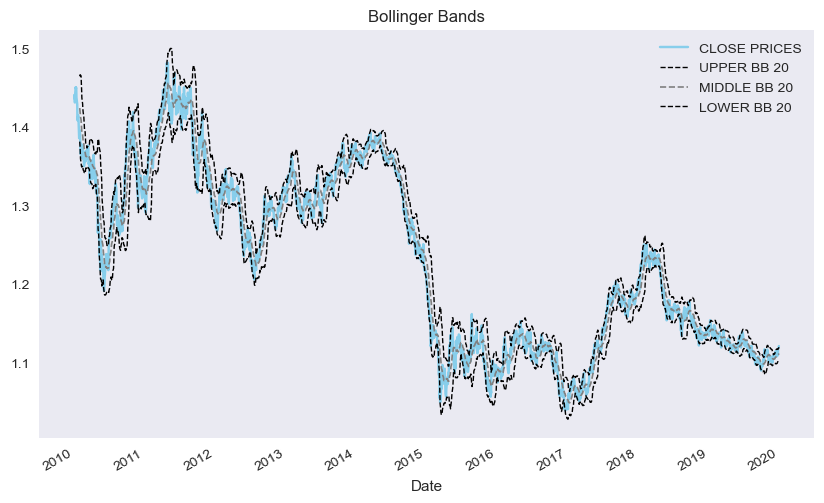

In [476]:
#Plot the figures with the bollinger bands
plt.figure(figsize=(10,6))
plt.title("FX Bollinger Bands")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', color = 'skyblue')
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.legend(loc='upper right')
plt.grid()
plt.show()

6. Generate the trading signals for the FX data

In [481]:
fx_buy_price, fx_sell_price, fx_bands_signal = implement_bands_strategy(pricing_data['Pricing'], pricing_data['Lower Band'], pricing_data['Upper Band'])

7. Plot a time-series of the FX Pricing Data, Simple Moving Average, Upper and Lower bands, indicating the sell and buy signals

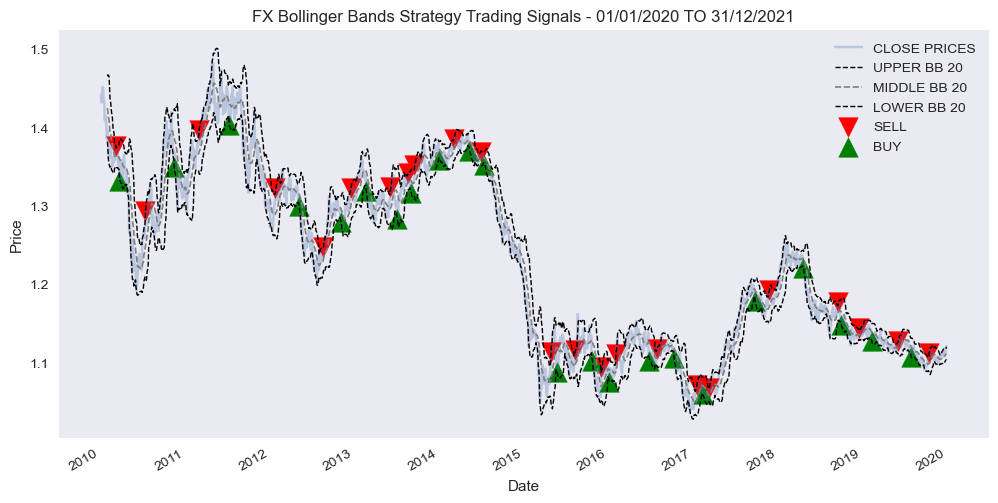

In [483]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("FX Bollinger Bands Strategy Trading Signals - 01/01/2020 TO 31/12/2021")
pricing_data['Pricing'].plot(label = 'CLOSE PRICES', alpha = 0.3)
pricing_data['Upper Band'].plot(label = 'UPPER BB 20', linestyle = '--', linewidth = 1, color = 'black')
pricing_data['SMA 20'].plot(label = 'MIDDLE BB 20', linestyle = '--', linewidth = 1.2, color = 'grey')
pricing_data['Lower Band'].plot(label = 'LOWER BB 20', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(pricing_data.index, fx_sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.scatter(pricing_data.index, fx_buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.grid()
plt.show()

8. Generate the positions of the data

In [487]:
fx_position = []
for i in range(len(fx_bands_signal)):
    if fx_bands_signal[i] > 1:
        fx_position.append(0)
    else:
        fx_position.append(1)
        
for i in range(len(pricing_data['Pricing'])):
    if fx_bands_signal[i] == 1:
        fx_position[i] = 1
    elif fx_bands_signal[i] == -1:
        fx_position[i] = 0
    else:
        fx_position[i] = fx_position[i-1]

In [489]:
#Add the bands_signal list to the main dataset
pricing_data.insert(loc = 2,column = 'Band Signals', value = fx_bands_signal)

#Add the positions list to the main dataset
pricing_data.insert(loc = 3,column = 'Band Position', value = position)

#Display the updated data
pricing_data.head()

ValueError: cannot insert Band Signals, already exists

9. Plot the market positions

In [ ]:
#Plot the market positions
plt.figure(figsize = (10,6))
plt.title("Market Positioning")
plt.xlabel("Date")
plt.ylabel("Position")
plt.plot(pricing_data['Band Position'])

10. Generate the 'Returns' and 'Strategy' data

In [490]:
#Calculate the returns on the data
pricing_data['Returns'] = np.log(pricing_data['Pricing'] / pricing_data['Pricing'].shift(1))

In [491]:
#Calculate the performance on the strategy data
pricing_data['Strategy'] = pricing_data['Band Position'].shift(1) * pricing_data['Returns']

In [492]:
#Compute the cummulative returns from the returns dataset
pricing_data['Cummulative Strategy'] = pricing_data['Strategy'].cumsum()
pricing_data['Cummulative Returns'] = pricing_data['Returns'].cumsum()

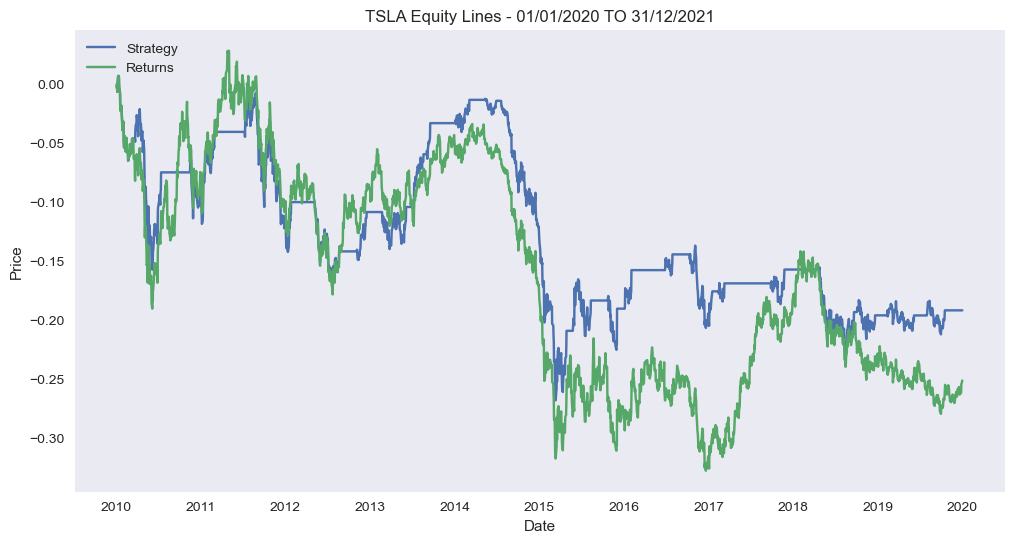

In [494]:
#Plot the cummulative returns and strategy data for the FX data
plt.figure(figsize = (12,6))
plt.title("TSLA Equity Lines - 01/01/2020 TO 31/12/2021")
plt.plot(pricing_data['Cummulative Strategy'], label = "Strategy")
plt.plot(pricing_data['Cummulative Returns'], label = "Returns")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.grid()
plt.show()